In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [2]:
# Setting untuk reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Import Libraries dan Setting
> **Penjelasan:** Mengimpor library yang dibutuhkan untuk manipulasi data, visualisasi, dan pemodelan KNN.

In [ ]:
df_train = pd.read_csv('../data/train.csv')
print(f"Dataset shape: {df_train.shape}")
print(f"Distribusi kelas target:\n{df_train['price_range'].value_counts().sort_index()}")

Dataset shape: (2000, 21)
Distribusi kelas target:
price_range
0    500
1    500
2    500
3    500
Name: count, dtype: int64


## 2. Load Data dan Tampilkan Informasi Awal
> **Penjelasan:** Memuat dataset train dan menampilkan ukuran serta distribusi kelas target untuk memastikan data seimbang.

In [ ]:
corr_matrix = df_train.corr()
correlation_with_price = corr_matrix['price_range'].sort_values(ascending=False)
print("\nTop 5 fitur dengan korelasi tertinggi:")
print(correlation_with_price.head(6))


Top 5 fitur dengan korelasi tertinggi:
price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
Name: price_range, dtype: float64


## 3. Visualisasi Korelasi Fitur dengan Target
> **Penjelasan:** Menghitung korelasi antara setiap fitur dengan target untuk memilih fitur penting dan memahami hubungan.

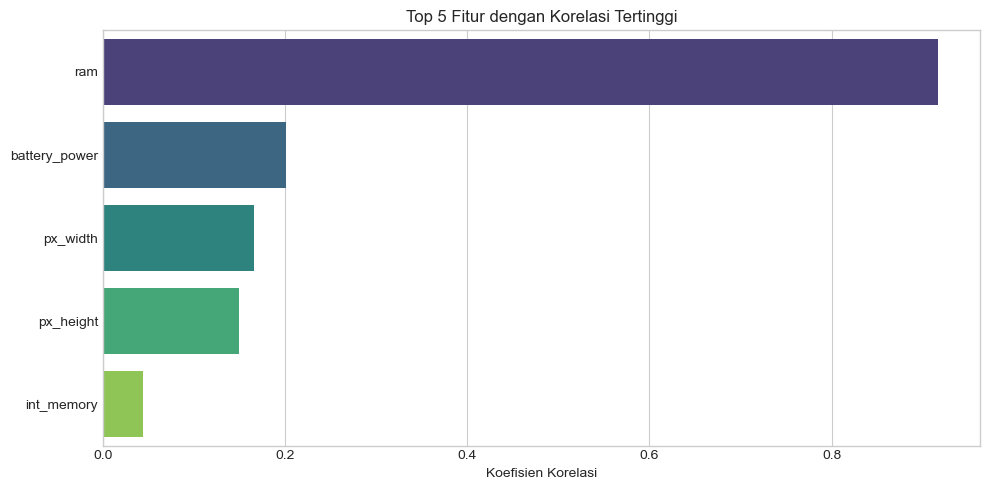

In [ ]:
plt.figure(figsize=(10, 5))
top_corrs = correlation_with_price.drop('price_range')
sns.barplot(x=top_corrs.nlargest(5).values, y=top_corrs.nlargest(5).index, palette='viridis')
plt.title('Top 5 Fitur dengan Korelasi Tertinggi')
plt.xlabel('Koefisien Korelasi')
plt.tight_layout()
plt.show()


## 4. Preprocessing Data: Standardisasi Fitur
> **Penjelasan:** Menstandarisasi fitur agar setiap variabel memiliki skala yang sama, penting karena KNN menggunakan jarak.

In [ ]:
X = df_train.drop('price_range', axis=1)
y = df_train['price_range']

In [8]:
# PENTING: Standardisasi fitur untuk KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 5. Train-Test Split dengan Stratifikasi
> **Penjelasan:** Membagi data menjadi train dan test dengan stratifikasi agar proporsi kelas target sama.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Optimalisasi Nilai K (Visualisasi Overfitting vs Underfitting)
> **Penjelasan:** Mencari nilai K terbaik dengan membandingkan akurasi train dan validation, serta menandai area overfitting.

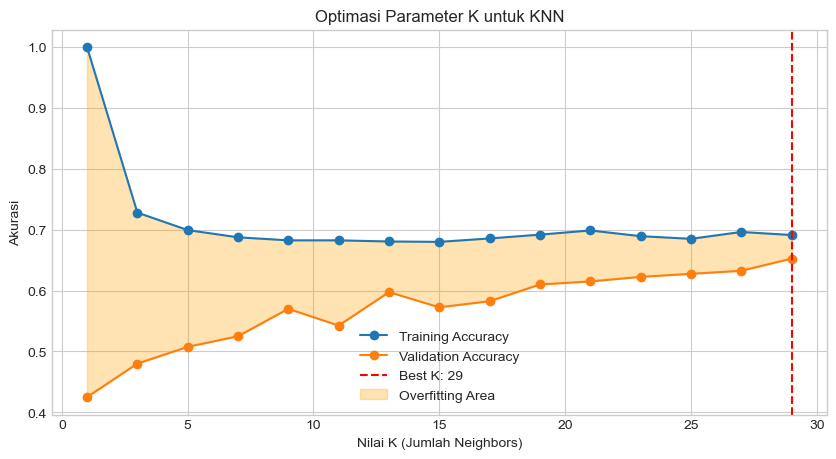

Nilai K optimal: 29
Akurasi validasi tertinggi: 0.6525


In [ ]:
def find_optimal_k(X_train, y_train, X_test, y_test):
    k_values = list(range(1, 30, 2))
    train_accuracy = []
    test_accuracy = []
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        train_accuracy.append(knn.score(X_train, y_train))
        test_accuracy.append(knn.score(X_test, y_test))
    
    # Visualisasi
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, train_accuracy, 'o-', label='Training Accuracy')
    plt.plot(k_values, test_accuracy, 'o-', label='Validation Accuracy')
    
    # Menandai K terbaik
    best_k = k_values[test_accuracy.index(max(test_accuracy))]
    plt.axvline(x=best_k, color='r', linestyle='--', 
               label=f'Best K: {best_k}')
    
    # Area overfitting
    plt.fill_between(k_values, train_accuracy, test_accuracy, 
                     where=(np.array(train_accuracy) > np.array(test_accuracy)),
                     color='orange', alpha=0.3, label='Overfitting Area')
    
    plt.xlabel('Nilai K (Jumlah Neighbors)')
    plt.ylabel('Akurasi')
    plt.title('Optimasi Parameter K untuk KNN')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_k, max(test_accuracy)

best_k, best_acc = find_optimal_k(X_train, y_train, X_test, y_test)
print(f"Nilai K optimal: {best_k}")
print(f"Akurasi validasi tertinggi: {best_acc:.4f}")


## 7. GridSearchCV untuk Tuning Parameter
> **Penjelasan:** Melakukan pencarian grid parameter di sekitar K optimal untuk mendapatkan konfigurasi terbaik.

In [ ]:
param_grid = {
    'n_neighbors': [best_k-2, best_k, best_k+2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
print("\nParameter terbaik:")
print(grid_search.best_params_)
print(f"Akurasi CV terbaik: {grid_search.best_score_:.4f}")


Parameter terbaik:
{'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'distance'}
Akurasi CV terbaik: 0.6594


## 8. Pelatihan Model Final dan Prediksi
> **Penjelasan:** Melatih model KNN menggunakan parameter terbaik, lalu memprediksi kelas pada data test.

In [ ]:
final_model = KNeighborsClassifier(**grid_search.best_params_)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)


## 9. Evaluasi Model
> **Penjelasan:** Mengukur performa model dengan akurasi, classification report, dan confusion matrix.


Akurasi model final: 0.7250


<Figure size 800x600 with 0 Axes>

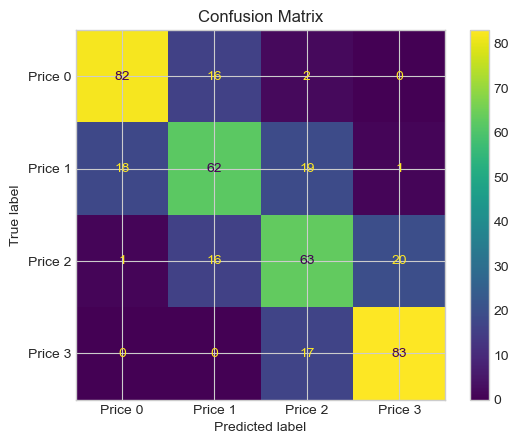

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi model final: {accuracy:.4f}")

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Price {i}" for i in range(4)])
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Price {i}' for i in range(4)]))



Classification Report:
              precision    recall  f1-score   support

     Price 0       0.81      0.82      0.82       100
     Price 1       0.66      0.62      0.64       100
     Price 2       0.62      0.63      0.63       100
     Price 3       0.80      0.83      0.81       100

    accuracy                           0.73       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



## 10. Visualisasi Decision Boundary dengan PCA
> **Penjelasan:** Mengurangi fitur menjadi 2 dimensi menggunakan PCA dan menggambar boundary KNN untuk memvisualisasi klasifikasi.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Melatih model KNN dengan data yang sudah di-PCA
pca_model = KNeighborsClassifier(**grid_search.best_params_)
pca_model.fit(X_train_pca, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=31, weights='distance')

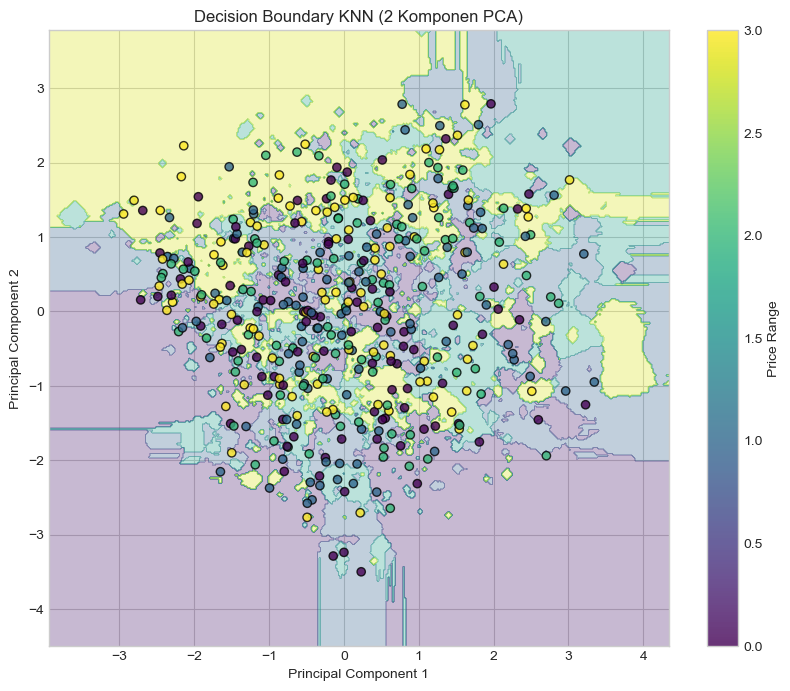

In [18]:
# Membuat mesh grid untuk visualisasi decision boundary
def plot_decision_boundary(X, y, model, ax=None):
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', 
                        cmap='viridis', alpha=0.8)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Decision Boundary KNN (2 Komponen PCA)')
    plt.colorbar(scatter, label='Price Range')
    plt.show()

# Visualisasi decision boundary KNN (kunci untuk menjelaskan cara kerja KNN)
plot_decision_boundary(X_test_pca, y_test, pca_model)

## 11. Prediksi Akhir pada `test.csv`
> **Penjelasan:** Menggunakan model final untuk membuat prediksi pada data baru (test.csv) dan menampilkan 5 teratas.

In [ ]:
df_test = pd.read_csv('../data/test.csv')
X_test_final = df_test.drop('id', axis=1)
X_test_final_scaled = scaler.transform(X_test_final)

test_predictions = final_model.predict(X_test_final_scaled)


In [21]:
# Hasil prediksi
results = pd.DataFrame({
    'id': df_test['id'],
    'predicted_price_range': test_predictions
})

print("\nHasil prediksi pada data testing (5 baris pertama):")
print(results.head())


Hasil prediksi pada data testing (5 baris pertama):
   id  predicted_price_range
0   1                      2
1   2                      2
2   3                      3
3   4                      3
4   5                      1


## 12. Kesimpulan dan Simpan Model
> **Penjelasan:** Ringkas hasil akhir dan simpan objek model serta scaler untuk digunakan di masa depan.

In [ ]:
print("\n" + "="*50)
print("RINGKASAN MODEL KNN UNTUK MOBILE PRICE CLASSIFICATION")
print("="*50)
print(f"• Parameter optimal: {grid_search.best_params_}")
print(f"• Akurasi final: {accuracy:.4f}")
print("\nTop 3 fitur terpenting berdasarkan korelasi:")

top_features = correlation_with_price[correlation_with_price.index != 'price_range'].head(3)
for feature, corr in top_features.items():
    print(f"• {feature}: {corr:.4f}")
print("="*50)


RINGKASAN MODEL KNN UNTUK MOBILE PRICE CLASSIFICATION
• Parameter optimal: {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'distance'}
• Akurasi final: 0.7250

Top 3 fitur terpenting berdasarkan korelasi:
• ram: 0.9170
• battery_power: 0.2007
• px_width: 0.1658


In [24]:
from joblib import dump

dump(final_model, 'knn_mobile_price_model.joblib')
dump(scaler,      'scaler_mobile_price.joblib')
print("Model dan scaler telah disimpan.")

Model dan scaler telah disimpan.
